## 论文题目：
### 利用自导航算法实现链子门近似编译 (Quantum gates approximate compilation for superconducting transmon qubit with self-navigation algorithm)

作者： 何润洪$^{1,3}$ , 任凤华$^2$, 解阳阳$^1$, 阿拉帕提·阿不力米提$^1$ and 王兆明$^1$ *

单位：1 中国海洋大学、2 青岛科技大学、3 中国科学院软件研究所

通信作者邮箱：* mingmoon78@126.com

### 内容简介： 

本文提出一种自导航算法，用以实现超导transmon量子系统中，单量子比特门的近似编译。评估结果显示，相比  U3 门执行方案，自导航算法设计的旋转路径大约仅为前者的2/3，可以显著缩短在利用平缓脉冲执行量子门时的所需时间，增加可行性的线路深度。无论精度要求多高，该算法都能以较低的成本设计合适的执行方案。随着精度要求的提高，自导航算法的控制方案设计时间、所用脉冲数都呈 $o[\mathrm{Log}(1/\epsilon)]$ 方式增长，且前因子很小。

安装依赖项

In [ ]:
!pip install scipy
!pip install numpy

加载依赖项

In [1]:
import numpy as np
from scipy.linalg import expm
from time import *

定义泡利算符和由目标单量子比特门构成的测试集
其中，目标单量子比特门由连续的 $RX$ 和 $RZ$ 门定义：

$$U=RZ(\theta_1)RX(\theta_2)RZ(\theta_3).$$

其中，
$$RZ(\theta)\begin{pmatrix}\exp(-i\theta/2)&0\\
                         0&\exp(i\theta/2)\end{pmatrix},$$

$$RX(\theta)=\begin{pmatrix}\cos(\theta/2)&-i\sin(\theta/2)\\
                       -i\sin(\theta/2)&\cos(\theta/2)\end{pmatrix}$$




其中 $\theta_1,\theta_2,\theta_3\in[0,2\pi)$。我们在定义域内随机选择角度，共构成 $128$ 个随机单量子比特幺正算符的测试集。

In [10]:
from mindquantum import *

sx = np.mat([[0,  1], [1, 0]], dtype=complex)
sy = np.mat([[0, -1j], [1j, 0]], dtype=complex)
sz = np.mat([[1, 0], [0, -1]], dtype=complex)

# 采用连续的两个 XZ 旋转方式产生任意量子门（忽略总体的相位因子）

random_paras = 2*np.pi*np.random.random([128, 3])

matrix_set = [] # 目标算符集
for paras in random_paras:
    circ = Circuit().rz(paras[0],0).rx(paras[1],0).rz(paras[2],0)
    matrix_set.append(np.mat(circ.matrix()))

将 HS 距离定义为门保真度，并据此计算同轴的两个旋转 $R_{\overrightarrow{n}}(\theta_{T})$ 和 $R_{\overrightarrow{n}}(\theta_{t})$ 之间的保真度。可得如下关系：
$$
\begin{aligned}F & =\left|\frac{\mathrm{Tr}\left[R_{\overrightarrow{n}}^{\dagger}(\theta_{T})R_{\overrightarrow{n}}(\theta_{t})\right]}{2}\right|{}^{2}\\
 & =\left|\mathrm{cos}(\frac{\triangle\theta}{2})\right|^{2}
\end{aligned},$$
其中 $\triangle\theta$ 为两个旋转之间的角度差。也即由两个保真度，可反推出两个同轴旋转之间角度的差值。

$$\triangle\theta=2\mathrm{arccos}(\sqrt{F})$$

但任意两个旋转之间不见得就是同轴的。本文采用动态规划的方式对其进行近似：先视两旋转为同轴；利用可实现能达到最高保真度的轴，近似执行旋转，得到新的矩阵，并以此类推，直到保真度达到提前设定的阈值为止。

在超导量子系统中，在旋转坐标系下，量子比特的哈密顿量为：$$H_{q}=-\frac{\hbar}{2}\Delta\sigma_{z},$$
其中，$\triangle$ 为旋转坐标系和量子比特的频率差。可用于实现比特绕 $z$-轴的旋转。当两者共振时，即 $\triangle=0$，可以施加在 $XY$-平面的旋转操作，哈密顿量为：
$$H_{d}=\frac{\hbar}{2}A(\cos\phi\sigma_{x}+\sin\phi\sigma_{y}),$$
其中 $\phi$ 为微波控制脉冲的相位补偿。通过调节 $\phi$ 可以调节旋转轴。

为作为近似轴，我们在 $\phi$ 的定义域上 $[0,2\pi) $上选取不同的值，也即可以得到不同数量的旋转轴。这里，为保证常规的绕 $x$ 和 $y$-轴的旋转操作一直存在，以更好的适用于量子线路模型，连带 $\pm z$-轴 我们选择四组方案：分别包括 3， 5， 9， 17 个可执行的旋转轴。

In [3]:
# 旋转轴选择策略: 直接选最优的
def step(matrix, target_matrix, F): 
    
    fid_list = []
    matrix_list = []
    fid0 = (np.abs(np.trace(target_matrix.H * matrix)/2)**2).item(0).real 
    rotation_angle = np.arccos(np.sqrt(fid0)) # 现有旋转 和 目标旋转 之间的 角度差, 表明了下一步的 旋转角度
    
    for axis in range(len(axis_space)):
        H = float(axis_space[axis,0])*sx/2 + float(axis_space[axis,1])*sy/2 + float(axis_space[axis,2])*sz/2
        U = expm(-1j * H * rotation_angle) 
        matrix_ = U * matrix
        fid = (np.abs(np.trace(target_matrix.H * matrix_)/2)**2).item(0).real 
        matrix_list.append(matrix_)
        fid_list.append(fid)
        
    best_axis = np.argmax(fid_list)
    best_fid = max(fid_list) 
        
    matrix_ = matrix_list[best_axis]
    rotation = [best_axis, rotation_angle]

    return  best_fid, matrix_, rotation

利用虚拟 $Z$ 门技术，可将一个绕 $z$-轴的旋转操作通过调节随后绕 $x$- 或 $y$-轴旋转脉冲的相位补偿来合并执行，不需要额外的脉冲和时间，且理论上保真度为 1。

$$\exp(-i\frac{\theta}{2}[\cos\phi\sigma_{x}+\sin\phi\sigma_{y}])=Z_{-\phi}X_{\theta}Z_{\phi}，$$

$$\exp(-i\frac{\theta}{2}[\cos(\frac{\pi}{2}+\phi)\sigma_{x}+\sin(\frac{\pi}{2}+\phi)\sigma_{y}])=Z_{-\phi}Y_{\theta}Z_{\phi}.$$

所以，可以在总的旋转路程中将其去掉。

In [4]:
def combined_rotations(rotations): # 若相邻两个旋转操作可以合并，就合并，以减少总的旋转次数。输入为 矩阵列表，输出为 数组列表。
                                   # 由于可以采用 虚拟 Z 门，来省略所有 Z 门，所以去掉所有 Z 旋转，不计入总的旋转距离
    rotations_no_z = []
    for i in rotations:
        if i[0] != num_z1:
            if i[0] != num_z2:
                rotations_no_z.append(i)
                
    combined_rotations = []
    j = 0
    if rotations_no_z != []:
        combined_rotations.append(rotations_no_z[0])
    
    for i in range(len(rotations_no_z)-1):
        if rotations_no_z[i][0] == rotations_no_z[i+1][0]:
            combined_rotations[j][1] += rotations_no_z[i+1][1]
        else:
            combined_rotations.append(rotations_no_z[i+1])
            j += 1           
        
    return combined_rotations

计算去掉绕 $\pm z$-轴旋转后得到的总的旋转距离。

In [5]:
def rotation_distance(combined_rotations):
    distance = 0
    for rotation in combined_rotations:
        distance += np.abs(rotation[1])
    rotation_step = len(combined_rotations)
    return distance, rotation_step 

主函数，可在指定保真度阈值，指定允许的旋转轴数下，计算验证集中所有量子门编译任务的保真度、旋转路程、所必须脉冲数（由于虚拟 Z 门技术，不包括 Z 轴旋转）和 设计时间。

In [6]:
def job(target_set):
    
    init_matrix = np.mat([[1, 0], [0, 1]], dtype=complex) # 对每个设计任务，其初始矩阵都是 单位矩阵
    fid_list = []  # 存储每个设计任务的最大保真度
    rotation_distance_list = [] # 用于存储每个设计任务中，总的必须旋转路程
    rotation_step_list = []
    time_cost_list = []
    
    for target_matrix in target_set:  
        
        rotations = [] # 用于存储每个步骤中的旋转情况, 形式为 list(np.mat([[-2.136, 0, 0]]), np.mat([0, 0.832, 0]]), ...)
        fid_max = 0
        
        start_time = time()
        matrix = init_matrix 
        F = (np.abs(np.trace(target_matrix.H * matrix)/2)**2).item(0).real 
        
        step_n = 0
        while True:
            
            F, matrix_ , rotation = step(matrix, target_matrix, F)
            fid_max = max(F, fid_max)
            rotations.append(rotation) # 将每一步的动作存储到列表中
            matrix = matrix_
            step_n += 1
    
            if fid_max > fid_threshold or step_n>step_max:
                break 
          
        fid_list.append(fid_max)
        end_time = time()
        time_cost = end_time - start_time
        time_cost_list.append(time_cost)
        
        combined_rotations_ = combined_rotations(rotations)
        rotation_distance_, rotation_step = rotation_distance(combined_rotations_)
        
        rotation_distance_list.append(rotation_distance_)
        rotation_step_list.append(rotation_step)
        
    return  fid_list, rotation_distance_list, rotation_step_list, time_cost_list

得到不同保真度阈值、不同数量的可允许旋转轴条件下，所有量子门编译任务的平均保真度、旋转路程、所必须脉冲数（由于虚拟 Z 门技术，不包括 Z 轴旋转）和 设计时间。

In [13]:
target_set = matrix_set
step_max = 50


for n in [0, 1, 3, 7]: # 允许的旋转轴总数为 3， 5， 9， 17
    axis_phi_num = 5+4*n # xy 平面允许的旋转轴数
                         # 总的允许旋转轴数为 5 + 4 * n - 1 + 2 (1：xy平面操作去掉和 0 相同的 2*pi; 2: 加上 z 轴正负两个方向 ) 
    axis_phi_space = np.delete(np.linspace(0,2*np.pi,axis_phi_num,endpoint=True),[-1])
    
    axis_space = [] #总的允许旋转轴空间，各列的每项分别代表着 sigma x, y, z 前面的系数。
    for axis_phi in axis_phi_space:
        axis_space.append([np.cos(axis_phi),np.sin(axis_phi),0])
    axis_space.append([0,0,1])
    axis_space.append([0,0,-1])
    axis_space = np.mat(axis_space)
    
    num_z1 = len(axis_space) -1  # 标记沿 z 轴旋转的序列数
    num_z2 = num_z1 - 1 # 标记沿 -z 轴旋转的序列数
    
    error_target_list = [0.0000001, 0.0000002, 0.0000004, 0.0000007,  0.000001, 0.000002, 0.000004, 0.000007, 0.00001, 0.00002, 0.00004, 0.00007, 0.0001, 0.0002, 0.0004, 0.0007, 0.001,  0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1]
    error_list_plot = []
    step_list_plot = []
    distance_list_plot = []
    time_cost_list_plot = []
    
    for error_target in error_target_list:
        fid_threshold = 1 - error_target
        fid_list, rotation_distance_list, rotation_step_list, time_cost_list = job(target_set)
        
        error_list_plot.append(1-np.mean(fid_list))
        step_list_plot.append(np.mean(rotation_step_list))
        distance_list_plot.append(np.mean(rotation_distance_list))
        time_cost_list_plot.append(np.mean(time_cost_list))
          
#         print(
#             # '-----------------------------------'
#           # '\n the fid_threshold is: \n', fid_threshold
#           # '\nthe mean_fid is: \n', np.mean(fid_list),
#           # '\nthe mean of rotation_step_list is: \n', np.mean(rotation_step_list),
#           # '\nthe mean of rotation_distance_list is: \n', np.mean(rotation_distance_list),
#           # '\nthe mean of time_cost_list is: \n', np.mean(time_cost_list)
#           )
    
    print('\nnum of allowed axis is: \n', len(axis_space)/2,
          '\nerror_target_list is: \n', error_target_list,
          '\nerror_list_plot is: \n', error_list_plot,
          '\nstep_list_plot is: \n', step_list_plot,
          '\n distance_list_plot is: \n', distance_list_plot,
          '\n time_cost_list_plot is: \n',time_cost_list_plot)


num of allowed axis is: 
 3.0 
error_target_list is: 
 [1e-07, 2e-07, 4e-07, 7e-07, 1e-06, 2e-06, 4e-06, 7e-06, 1e-05, 2e-05, 4e-05, 7e-05, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1] 
error_list_plot is: 
 [7.186080308585474e-08, 1.3782654484373325e-07, 2.841176245382826e-07, 4.760750296206595e-07, 6.898761213403048e-07, 1.3831946105158366e-06, 2.7559026676282627e-06, 4.87925119185828e-06, 6.779088269848188e-06, 1.346385016243179e-05, 2.77489829256794e-05, 4.9077091312188514e-05, 6.90934635030338e-05, 0.00014013087002606728, 0.000280612240255218, 0.00048003008552433, 0.0006715969492581131, 0.001397128073274967, 0.00285648246110215, 0.00496178673004688, 0.006786097598501684, 0.013463759326985403, 0.027160885586550387, 0.043756117535378225, 0.06558924391983267] 
step_list_plot is: 
 [9.8984375, 9.53125, 9.0078125, 8.6328125, 8.3984375, 7.921875, 7.46875, 7.0390625, 6.828125, 6.40625, 5.9609375, 5.578125, 5.3125, 4.875, 4.3984375, 4.0703125, 

运行结果为：

In [ ]:
num of allowed axis is: 
 3.0 
error_target_list is: 
 [1e-07, 2e-07, 4e-07, 7e-07, 1e-06, 2e-06, 4e-06, 7e-06, 1e-05, 2e-05, 4e-05, 7e-05, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1] 
error_list_plot is: 
 [7.186080308585474e-08, 1.3782654484373325e-07, 2.841176245382826e-07, 4.760750296206595e-07, 6.898761213403048e-07, 1.3831946105158366e-06, 2.7559026676282627e-06, 4.87925119185828e-06, 6.779088269848188e-06, 1.346385016243179e-05, 2.77489829256794e-05, 4.9077091312188514e-05, 6.90934635030338e-05, 0.00014013087002606728, 0.000280612240255218, 0.00048003008552433, 0.0006715969492581131, 0.001397128073274967, 0.00285648246110215, 0.00496178673004688, 0.006786097598501684, 0.013463759326985403, 0.027160885586550387, 0.043756117535378225, 0.06558924391983267] 
step_list_plot is: 
 [9.8984375, 9.53125, 9.0078125, 8.6328125, 8.3984375, 7.921875, 7.46875, 7.0390625, 6.828125, 6.40625, 5.9609375, 5.578125, 5.3125, 4.875, 4.3984375, 4.0703125, 3.78125, 3.328125, 2.890625, 2.578125, 2.390625, 2.015625, 1.671875, 1.3984375, 1.2265625] 
 distance_list_plot is: 
 [2.0268239198095768, 2.0266321070983633, 2.026277510723003, 2.0259022262501367, 2.0256042990618988, 2.024839584230116, 2.0238588886263287, 2.0226007935769914, 2.02175525243611, 2.0195359384059532, 2.016223439104864, 2.0122971961418257, 2.0092230718252595, 2.002271040177818, 1.9914700774106193, 1.9816761703542507, 1.9713835319148463, 1.949299319142685, 1.9165877390066282, 1.8828729203779817, 1.8595661018738177, 1.7918649710375982, 1.695512437049873, 1.6058031620001676, 1.5271641260154167] 
 time_cost_list_plot is: 
 [0.03959328681230545, 0.05127017758786678, 0.04616949148476124, 0.04417860880494118, 0.043241338804364204, 0.0391265582293272, 0.03734815865755081, 0.03639747016131878, 0.03406319208443165, 0.033555664122104645, 0.029835911467671394, 0.027954572811722755, 0.02698884718120098, 0.028441423550248146, 0.02660220116376877, 0.021314818412065506, 0.01982339471578598, 0.01847793161869049, 0.016466869041323662, 0.014065338298678398, 0.013645755127072334, 0.011683685705065727, 0.009597910568118095, 0.008281312882900238, 0.008100856095552444]

num of allowed axis is: 
 5.0 
error_target_list is: 
 [1e-07, 2e-07, 4e-07, 7e-07, 1e-06, 2e-06, 4e-06, 7e-06, 1e-05, 2e-05, 4e-05, 7e-05, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1] 
error_list_plot is: 
 [6.424245713176902e-08, 1.4026954642254452e-07, 2.687214060159704e-07, 4.7638066646982224e-07, 6.739878685158018e-07, 1.2478084393530153e-06, 2.6171248701523098e-06, 4.716195911913523e-06, 6.373046265273352e-06, 1.3184315916903167e-05, 2.700016128809324e-05, 4.6274155804049144e-05, 6.517868088118384e-05, 0.000140390104562238, 0.00025773260891570615, 0.00045926239353821785, 0.0006706530102426056, 0.0012936297139265474, 0.0026441348770991357, 0.004586837145340139, 0.006091565200916915, 0.012913970624772508, 0.025534586116497948, 0.04314879068941935, 0.06131483250891323] 
step_list_plot is: 
 [5.8203125, 5.5546875, 5.375, 5.1640625, 5.03125, 4.8671875, 4.6484375, 4.5, 4.4140625, 4.1328125, 3.9296875, 3.796875, 3.6796875, 3.4140625, 3.21875, 3.0625, 2.9296875, 2.7265625, 2.4609375, 2.2265625, 2.1875, 1.84375, 1.6640625, 1.484375, 1.328125] 
 distance_list_plot is: 
 [1.8789631488683665, 1.878790197831984, 1.8786131229437513, 1.8783073331094364, 1.8781029048395865, 1.8777584556521298, 1.87693763415828, 1.8762053571359325, 1.8757796109516087, 1.8738896378603926, 1.8715940031991591, 1.8693244421708157, 1.8677737454158454, 1.8623680473833129, 1.855148683337661, 1.8480721979060717, 1.8405056671459308, 1.8281719395664244, 1.8032067192552845, 1.7786267730769303, 1.7658987725868354, 1.6999693877645656, 1.6310864883837737, 1.5544196784311164, 1.4882063510634067] 
 time_cost_list_plot is: 
 [0.07149807177484035, 0.06723693013191223, 0.06575245596468449, 0.06657637841999531, 0.06661064736545086, 0.05649974383413792, 0.055035125464200974, 0.05252781696617603, 0.05136859975755215, 0.047382211312651634, 0.04501541145145893, 0.04207712225615978, 0.040784601122140884, 0.03634293004870415, 0.03653823025524616, 0.03388248570263386, 0.030401017516851425, 0.02770521305501461, 0.02781742997467518, 0.02256135269999504, 0.02078835666179657, 0.01782020926475525, 0.015258779749274254, 0.013433221727609634, 0.011294722557067871]

num of allowed axis is: 
 9.0 
error_target_list is: 
 [1e-07, 2e-07, 4e-07, 7e-07, 1e-06, 2e-06, 4e-06, 7e-06, 1e-05, 2e-05, 4e-05, 7e-05, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1] 
error_list_plot is: 
 [7.003083835055435e-08, 1.2127464898981088e-07, 2.644990951816695e-07, 4.794637626925891e-07, 6.159563259444667e-07, 1.3162503108565815e-06, 2.686501571647071e-06, 4.51041051174883e-06, 6.48955447379862e-06, 1.2551846120589794e-05, 2.5894192205444533e-05, 4.441414878830763e-05, 6.412829856938806e-05, 0.00013215710334946174, 0.000263229895915873, 0.000438748840546177, 0.0006514379555270233, 0.001301161877162782, 0.0025885892792852916, 0.004580863297891091, 0.006546702417086658, 0.012416254777781521, 0.027288590213064623, 0.04227509518129291, 0.059079641541013306] 
step_list_plot is: 
 [5.96875, 5.7890625, 5.5234375, 5.359375, 5.265625, 4.984375, 4.7578125, 4.578125, 4.4765625, 4.2265625, 4.0078125, 3.8671875, 3.75, 3.53125, 3.3203125, 3.203125, 3.0546875, 2.8359375, 2.5625, 2.3515625, 2.25, 1.9765625, 1.765625, 1.5390625, 1.3984375] 
 distance_list_plot is: 
 [1.8458887086614995, 1.845775543456457, 1.8455188346478186, 1.8452978342841362, 1.845189698419381, 1.8447019122873674, 1.8440142755669973, 1.8433036103881513, 1.8426428348180601, 1.84113242080215, 1.8390525745798245, 1.837114439241266, 1.8351400120653856, 1.8306663314107365, 1.8238848128758702, 1.818021976997136, 1.8105915361734257, 1.796892014274173, 1.7734204401035432, 1.7511688146419844, 1.7327439837778558, 1.6845455008305006, 1.6151708025198892, 1.546640844531857, 1.493886418621847] 
 time_cost_list_plot is: 
 [0.12580826692283154, 0.11820930801331997, 0.13230480439960957, 0.12180386297404766, 0.11558120138943195, 0.10568590462207794, 0.09621499478816986, 0.09008779376745224, 0.08582968264818192, 0.08164195902645588, 0.07611929625272751, 0.0721444170922041, 0.07023309357464314, 0.06576457992196083, 0.059495873749256134, 0.05812755040824413, 0.051860203966498375, 0.05070791393518448, 0.04221503436565399, 0.04356786981225014, 0.040370263159275055, 0.0317077599465847, 0.02941981889307499, 0.02410537749528885, 0.022021742537617683]

num of allowed axis is: 
 17.0 
error_target_list is: 
 [1e-07, 2e-07, 4e-07, 7e-07, 1e-06, 2e-06, 4e-06, 7e-06, 1e-05, 2e-05, 4e-05, 7e-05, 0.0001, 0.0002, 0.0004, 0.0007, 0.001, 0.002, 0.004, 0.007, 0.01, 0.02, 0.04, 0.07, 0.1] 
error_list_plot is: 
 [6.79972498307535e-08, 1.2445314712117295e-07, 2.4866130088341265e-07, 4.7051293683431084e-07, 6.644596537430658e-07, 1.3144664139375095e-06, 2.6792071770032067e-06, 4.488304496952367e-06, 6.3544628083889165e-06, 1.2714296712568185e-05, 2.5824620925818387e-05, 4.604266821051084e-05, 6.378492152214754e-05, 0.00013029672654041313, 0.00025994649084737365, 0.00045238820029280813, 0.0006594341805234993, 0.001295900479341472, 0.002532033067244921, 0.004427877987631557, 0.006386566346808342, 0.012527475872194715, 0.026992268945852715, 0.04085379219192298, 0.05724690007471178] 
step_list_plot is: 
 [5.9453125, 5.7890625, 5.4921875, 5.3203125, 5.234375, 5.0625, 4.9296875, 4.78125, 4.65625, 4.453125, 4.265625, 4.0234375, 3.921875, 3.703125, 3.40625, 3.265625, 3.1171875, 2.90625, 2.671875, 2.4765625, 2.390625, 2.140625, 1.9296875, 1.734375, 1.578125] 
 distance_list_plot is: 
 [1.8351448760107676, 1.8350301069405708, 1.8347928458123448, 1.8345844939035052, 1.834410534207152, 1.8339024154452153, 1.8333437335681415, 1.832547642671283, 1.831943307180659, 1.8305800129485372, 1.8287298633556346, 1.8260261132775113, 1.8242494292565263, 1.8203122596616037, 1.8134237911190403, 1.8069059958999083, 1.8007225914730376, 1.785534668893145, 1.7660368042952483, 1.7444218375923306, 1.7278137416870232, 1.674362321938566, 1.6027165329190336, 1.5385516115617897, 1.4790231791100301] 
 time_cost_list_plot is: 
 [0.21567616239190102, 0.2117284331470728, 0.20246202684938908, 0.19032949581742287, 0.2024741843342781, 0.17482208274304867, 0.17675597965717316, 0.15998758375644684, 0.155161552131176, 0.15217009373009205, 0.13443676568567753, 0.1295544933527708, 0.12917428277432919, 0.12118035741150379, 0.10595317743718624, 0.0983518660068512, 0.09338076040148735, 0.08498757518827915, 0.0803587008267641, 0.06723202392458916, 0.06415948271751404, 0.05340554006397724, 0.04638146422803402, 0.040539294481277466, 0.03650876693427563]

以上数据结果为在一台主频为 1.8GHz 的 4 核且内存为 8 GB 的经典计算机上进行的模拟结果。

目标精度 $\epsilon_{T}$ 与平均实际精度 $\bar{\epsilon}$ 的对比图。图中虚线为两者相等的界限。可见，无论采用哪组旋转轴，在算法结束时，实际精度都高于目标精度。

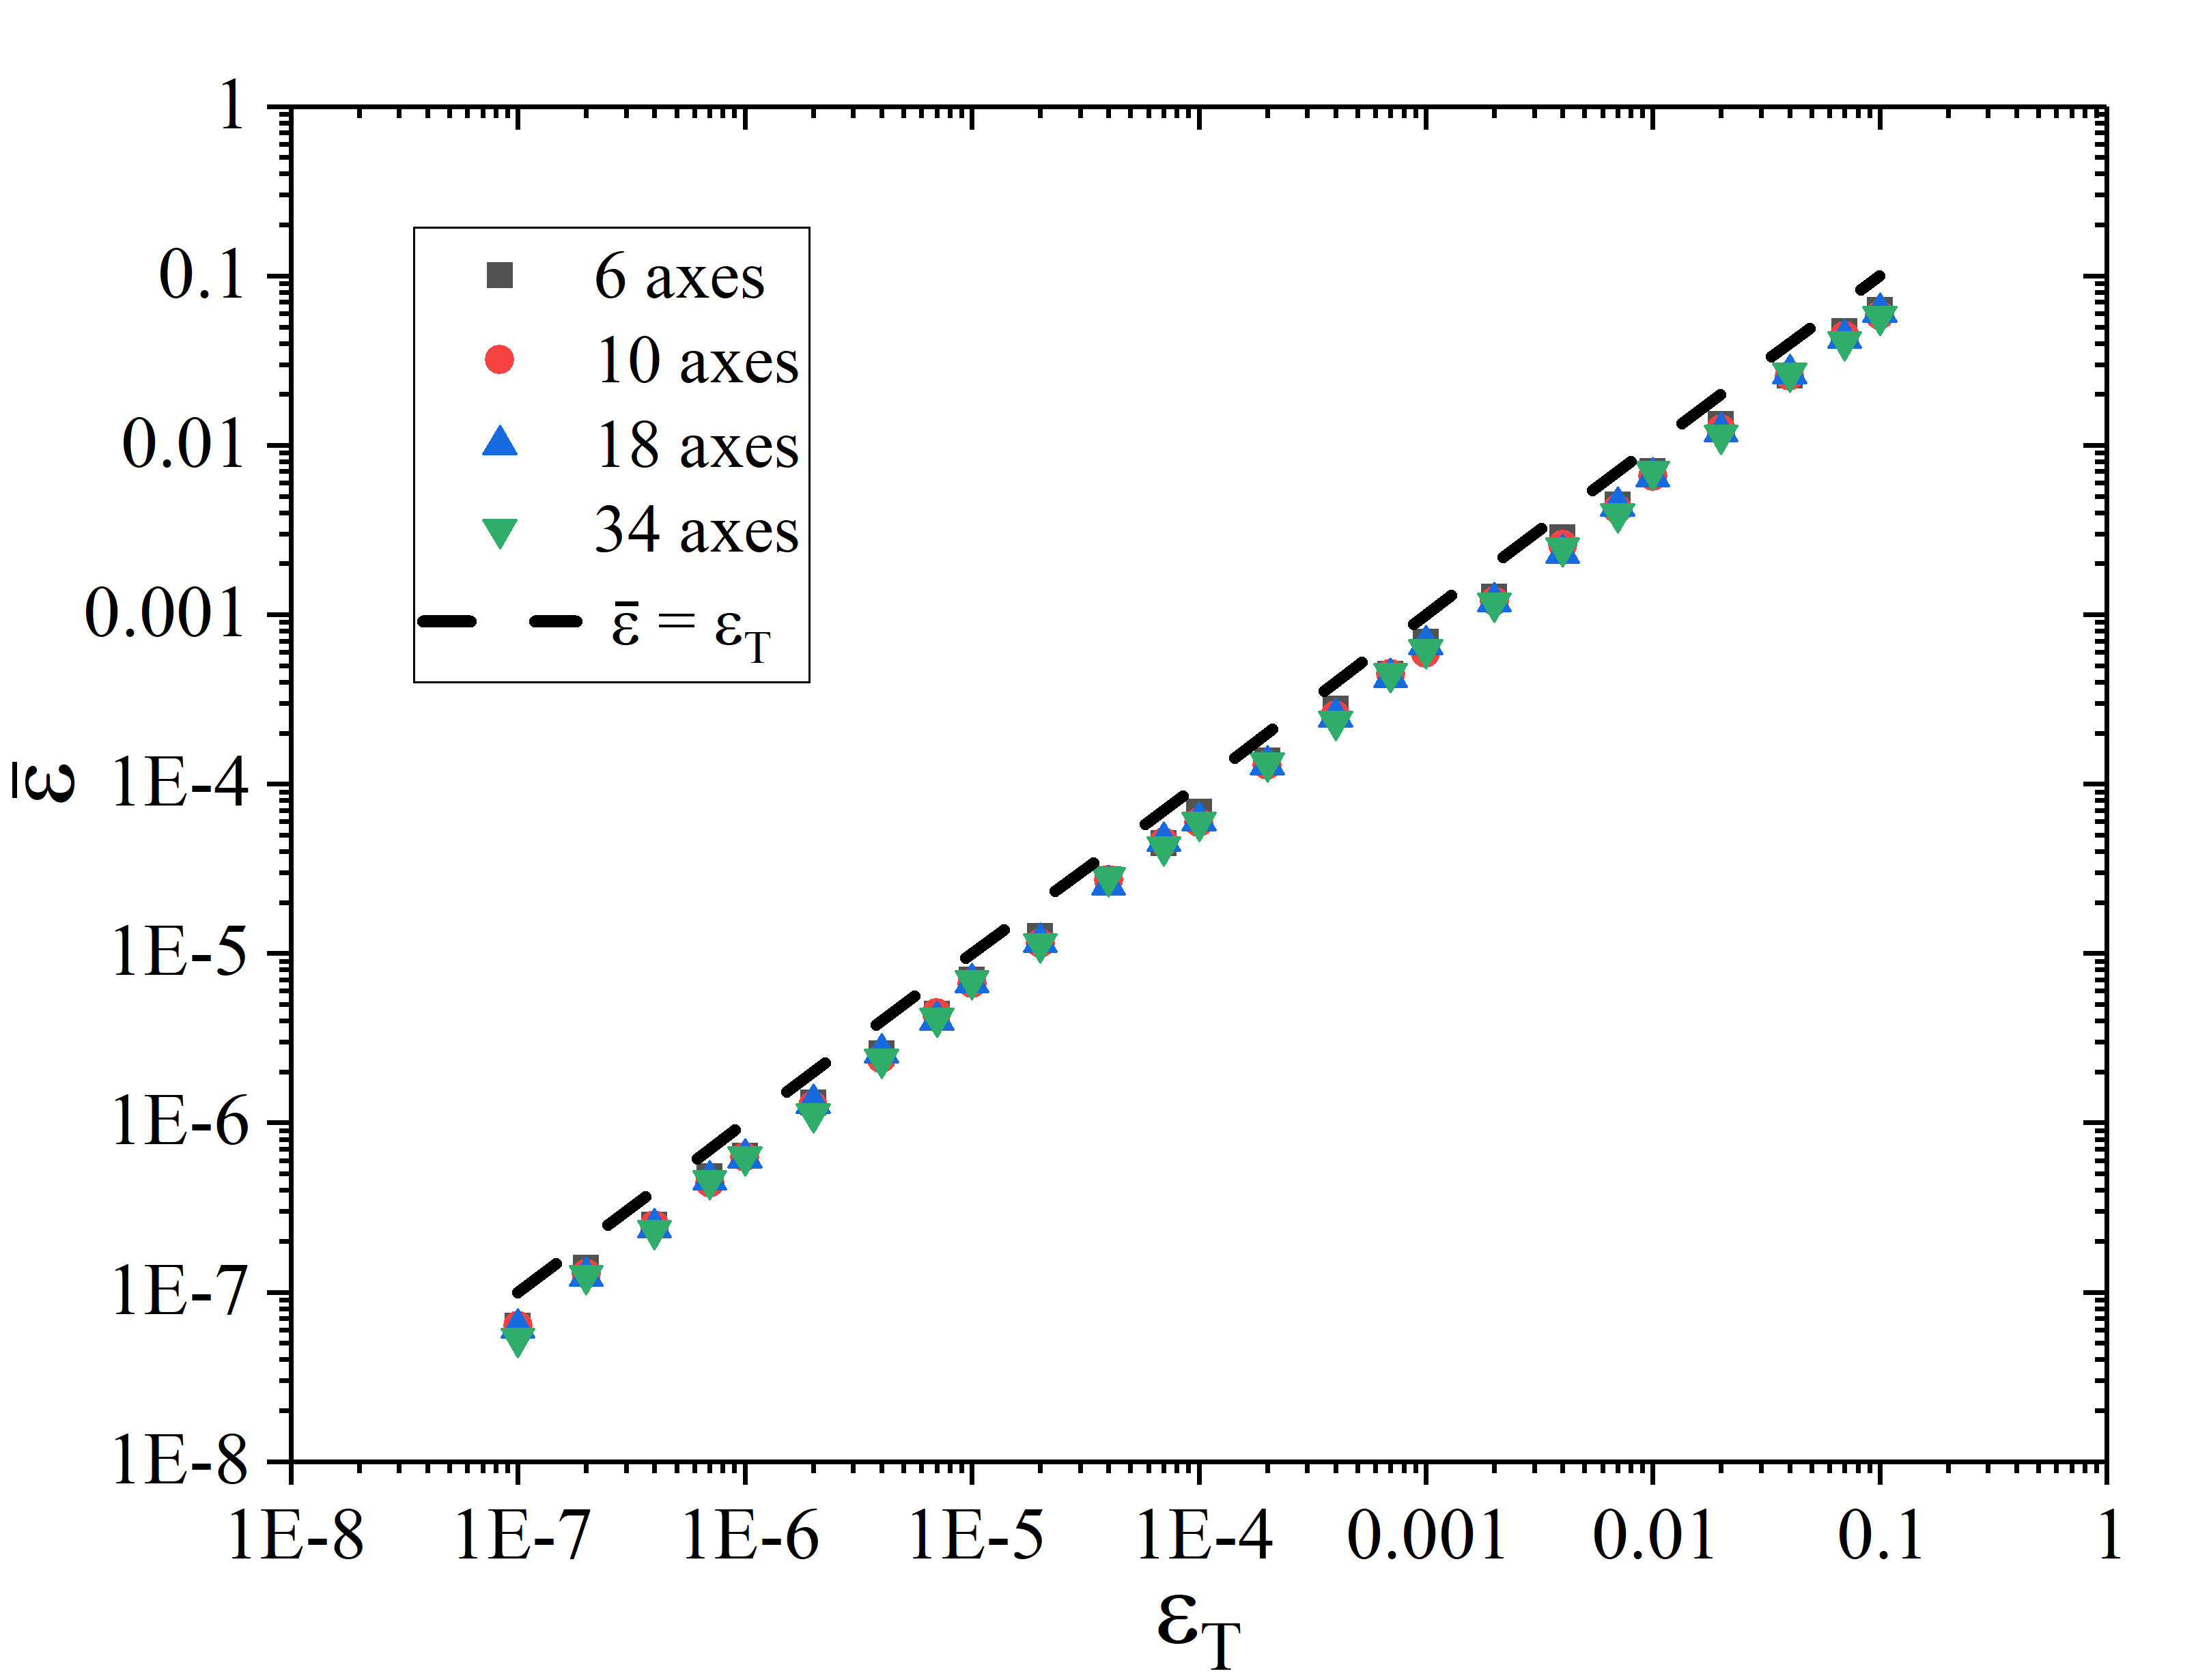

不同组别下，平均总的旋转距离 $\bar{d}$ 和目标精度之间的关系图。可见，允许旋转轴数越多，所需旋转距离越短，但到了 18 个，增长趋势基本停止。表明 18 个允许轴数已足够。最终总的旋转距离随着精度要求的提高而增加，但呈现收敛趋势。最小收敛极限大致为 2.2，这明显短语 U3 门所采必须的距离（$\pi$）。

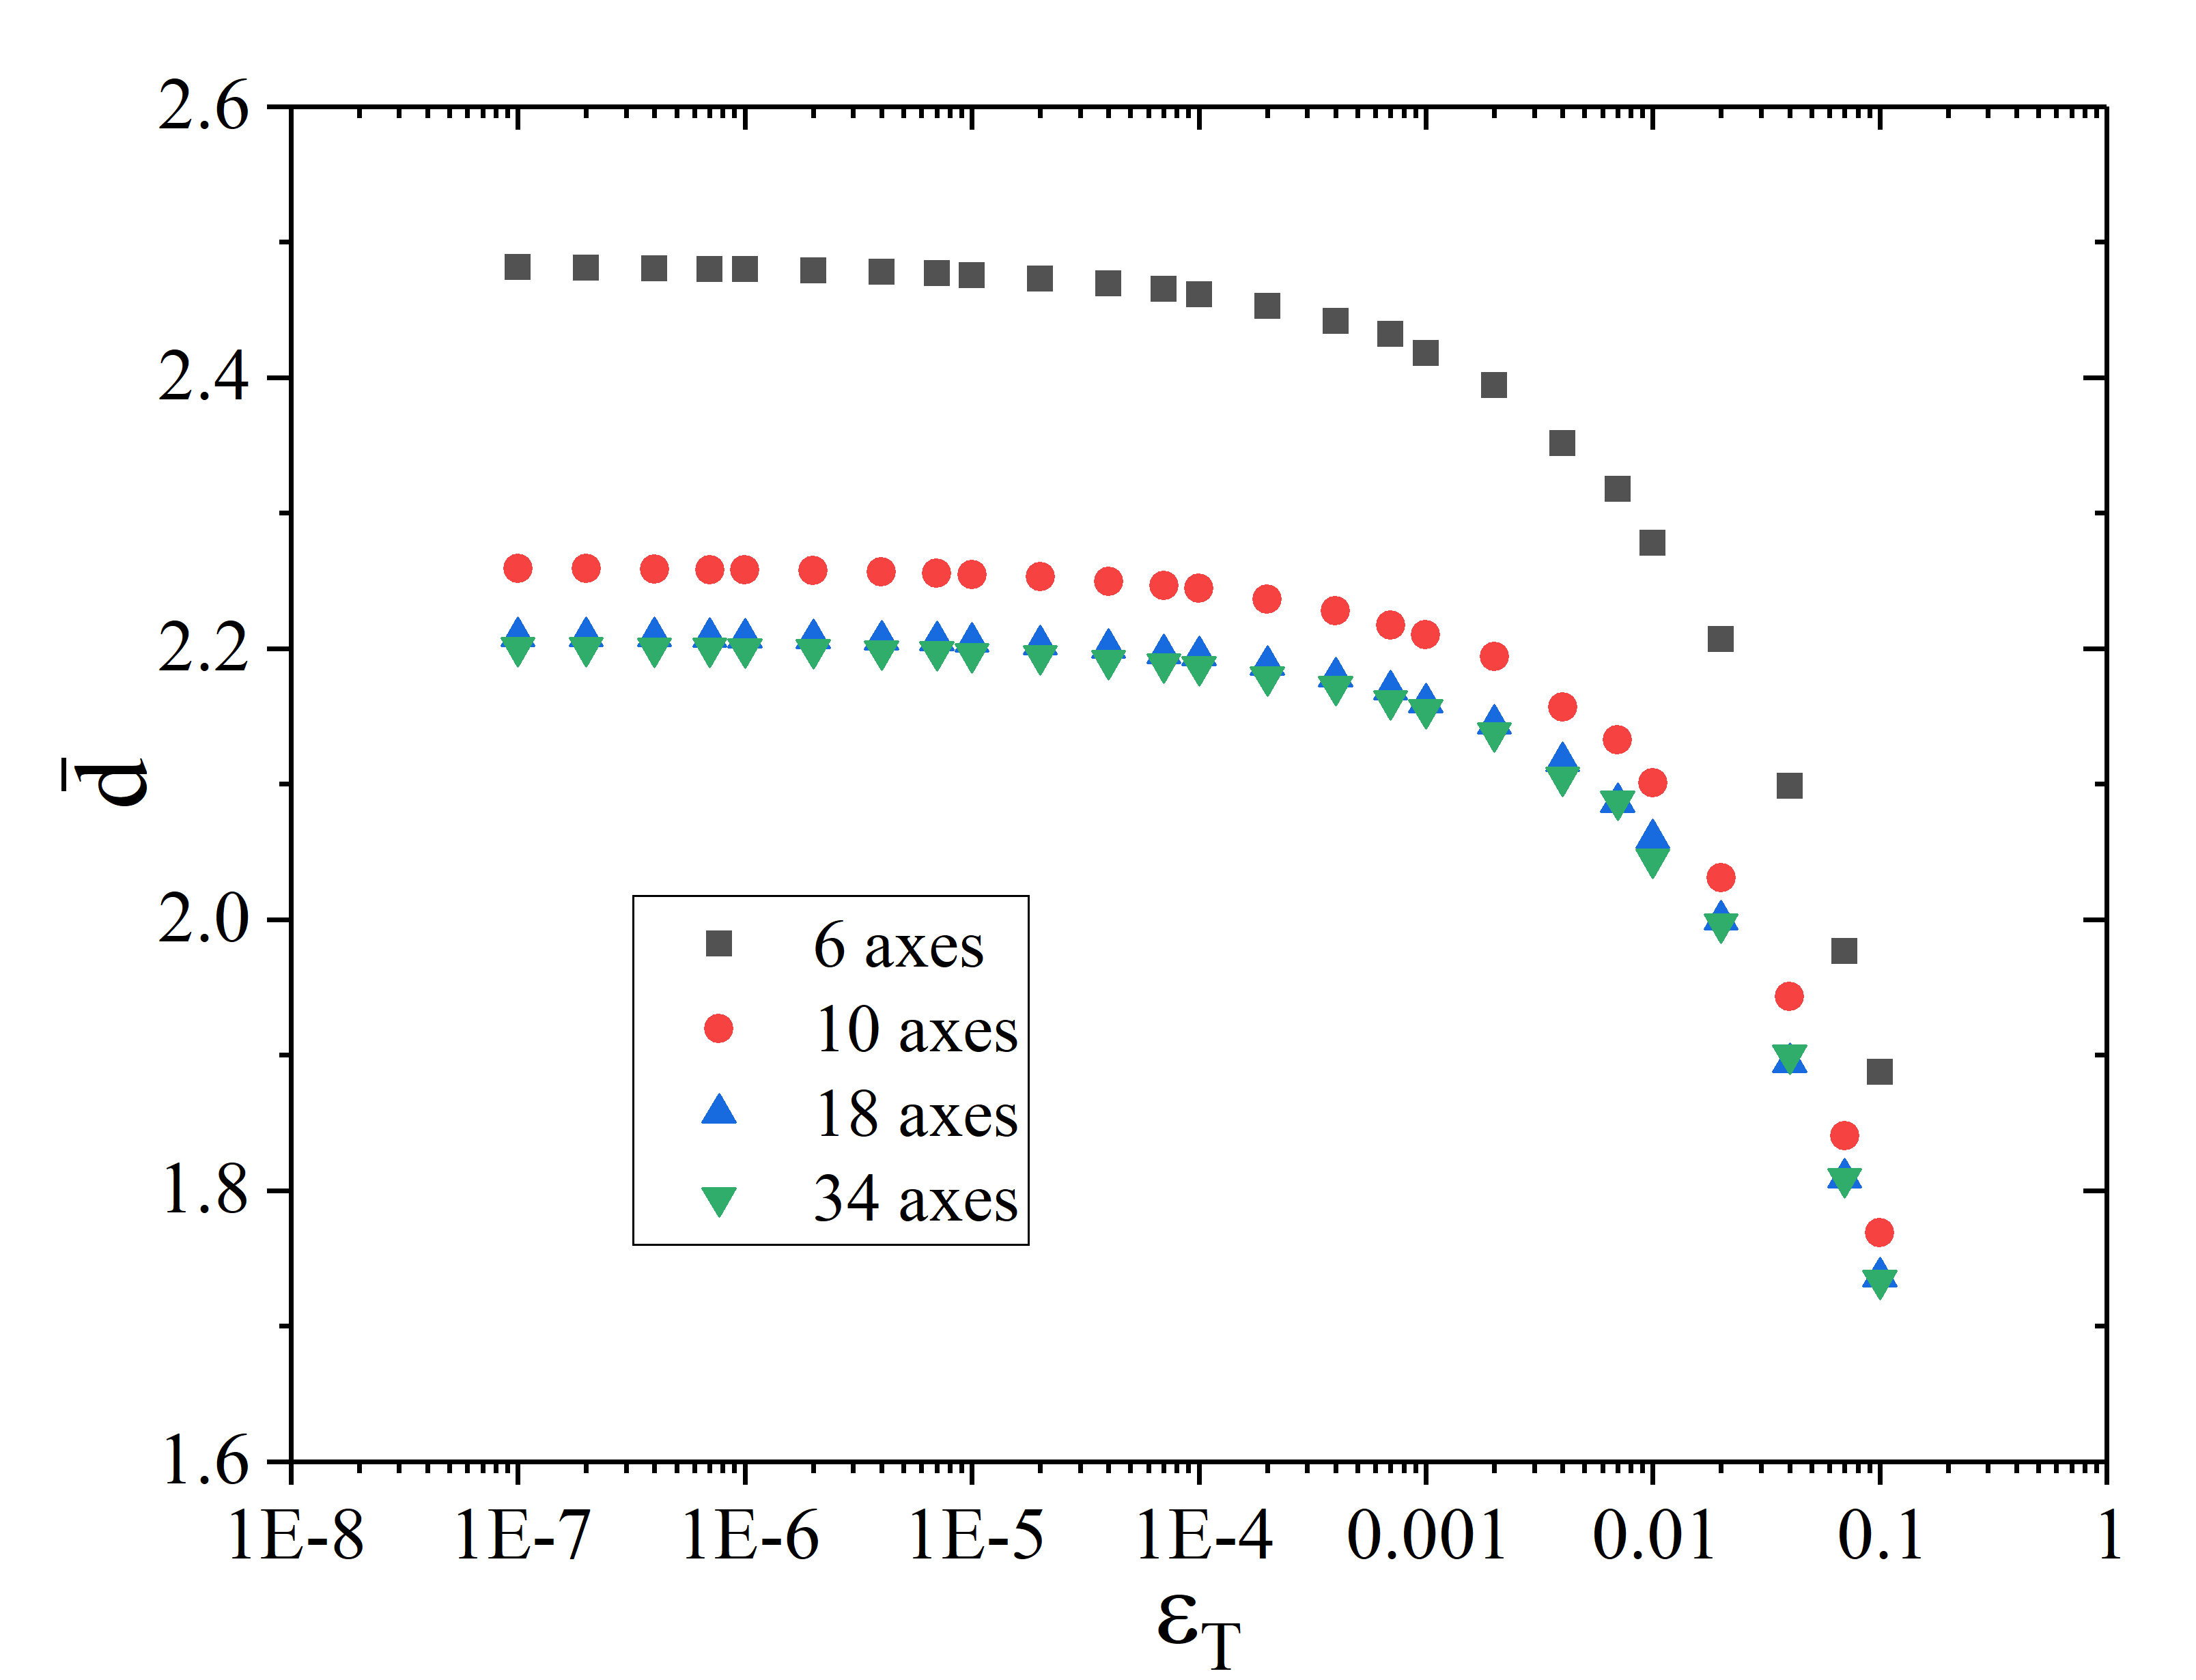

不同组别下，平均所须执行脉冲数 $\bar{n}$ 与目标精度的关系图。可见允许轴数越多，所须 $\bar{n}$ 越少，但这种趋势也在逐渐减弱。随着目标精度提高，所须 $\bar{n}$ 成 $o[\mathrm{1/\epsilon}]$ 增长，且其前因子很小。

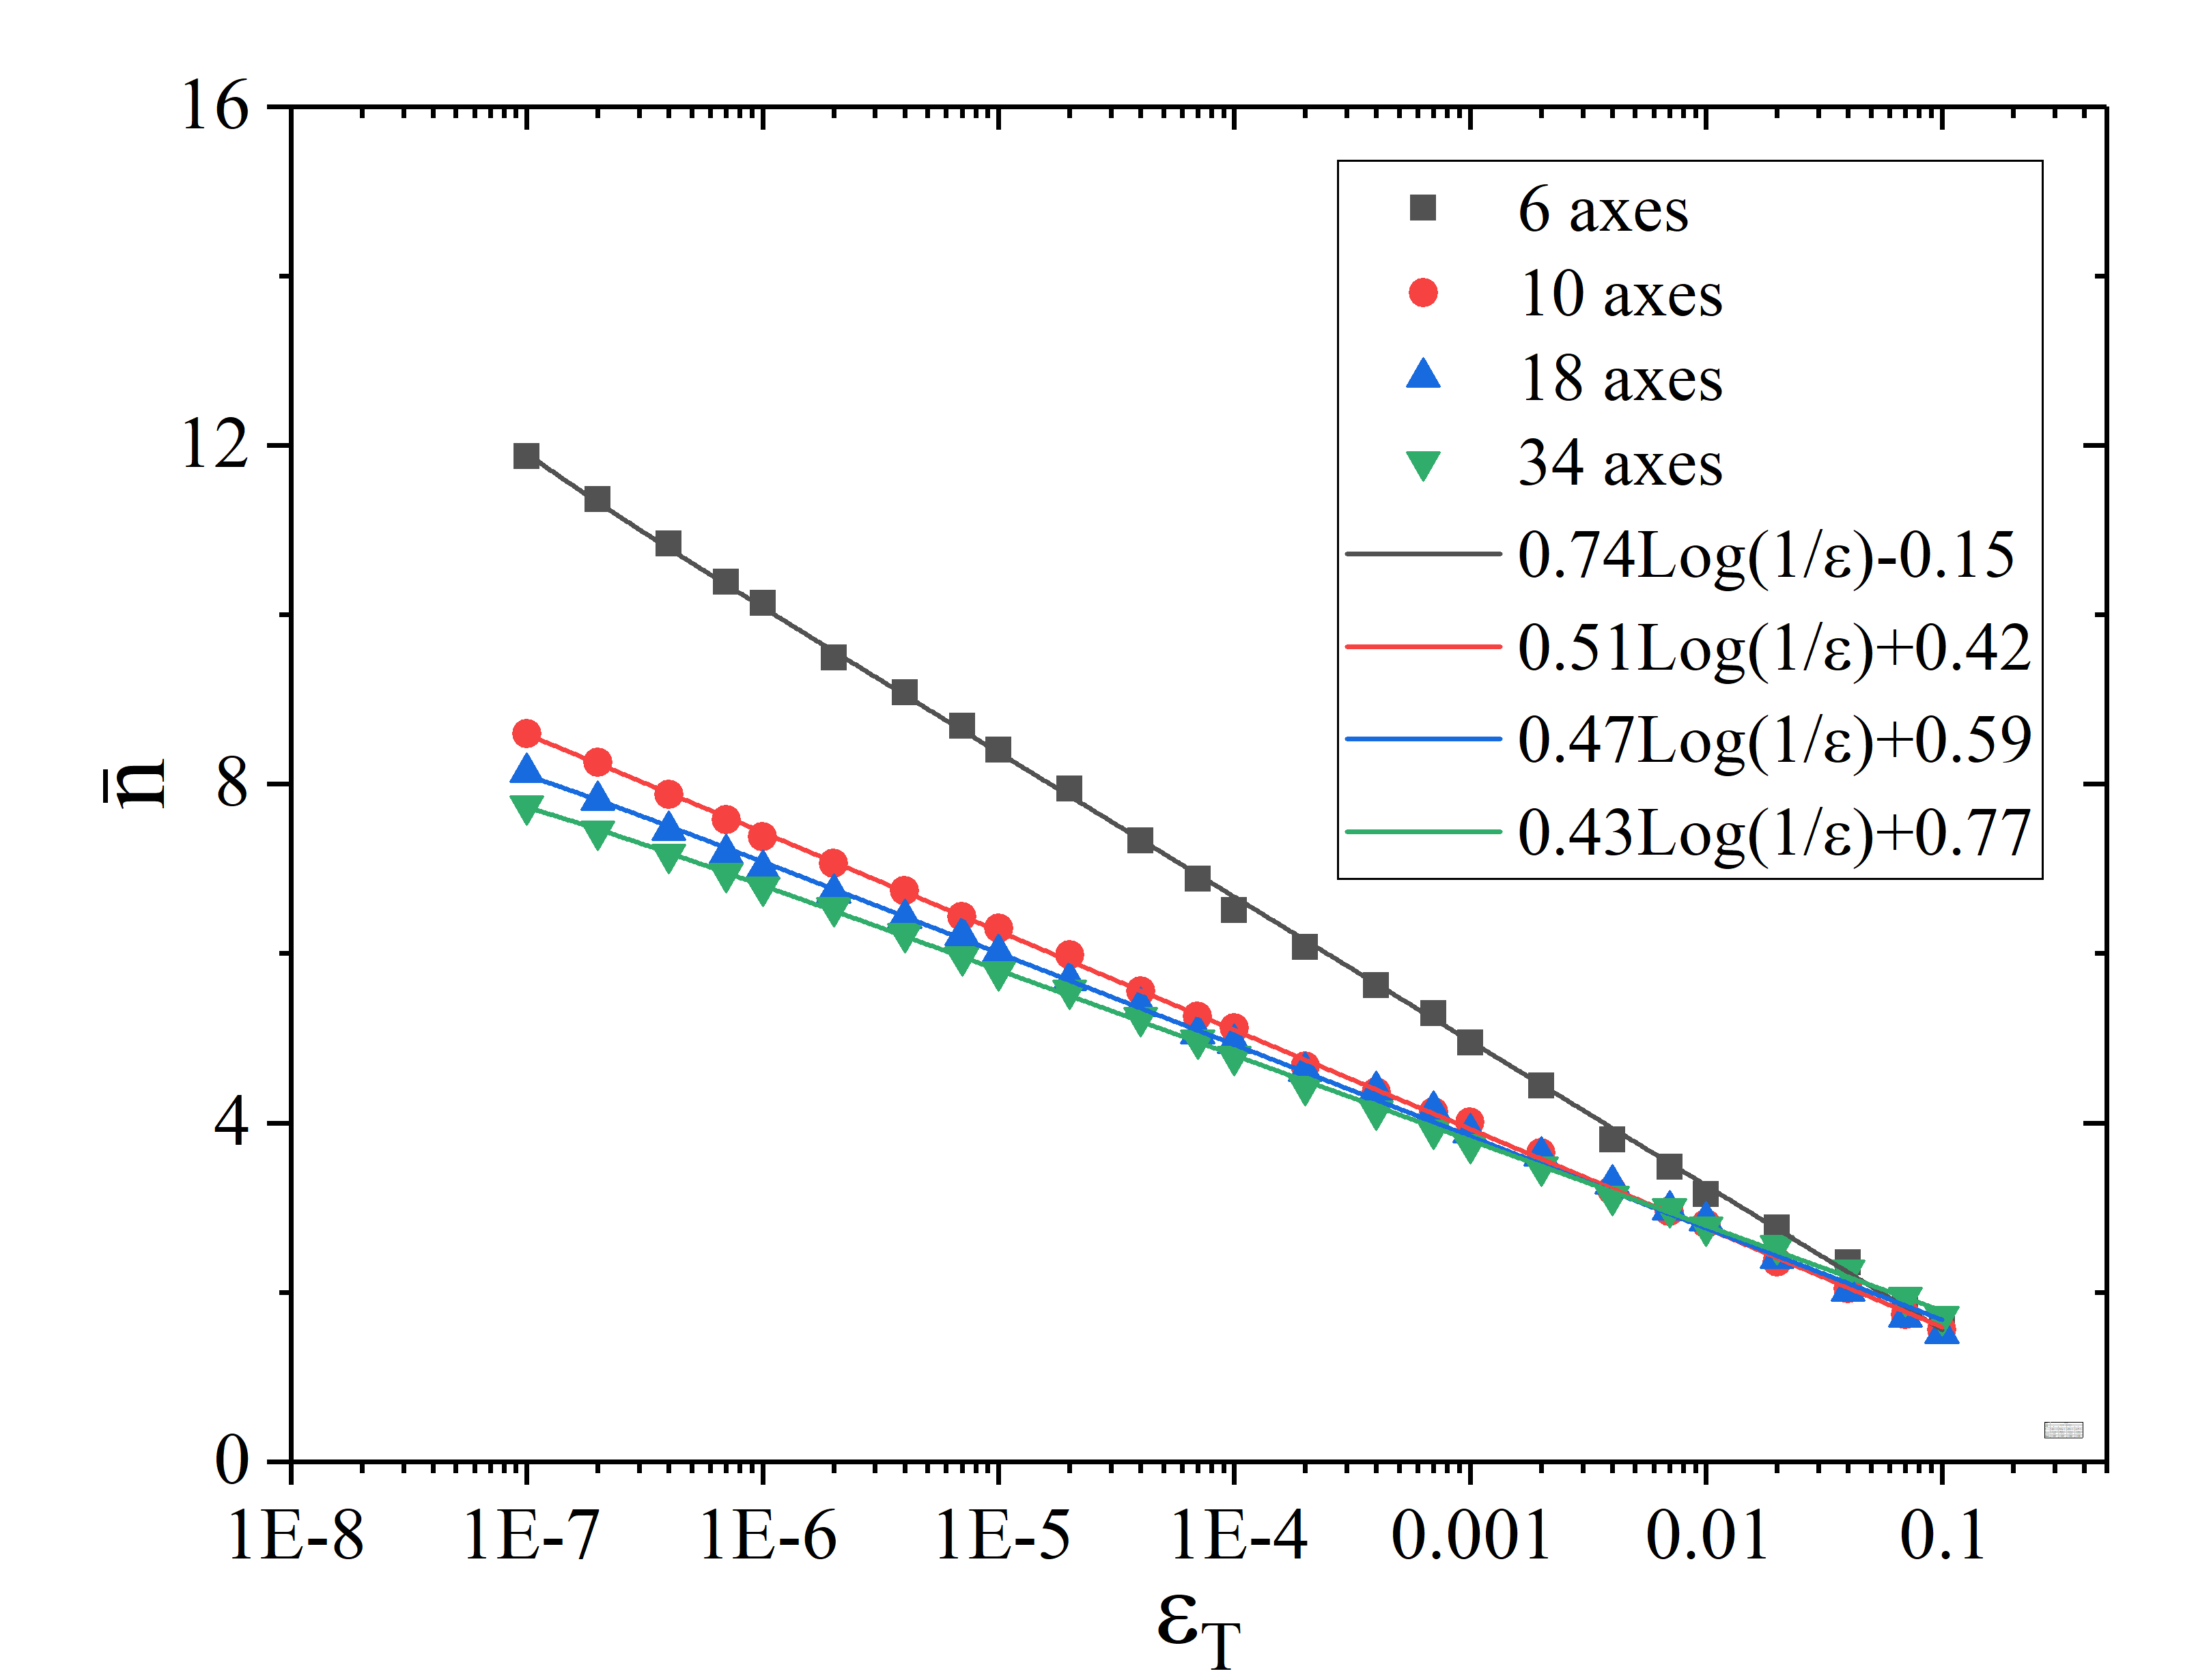

不同组别下，执行算法设计控制方案达到目标精度平均所用时间（单位：秒）。这反映了算法效率，可见随着目标精度提高，所须 $\bar{t}$ 成 $o[\mathrm{1/\epsilon}]$ 增长，其前因子也很小。 所用轴数越少，花费时间越少，但这种趋势也在逐渐减弱。

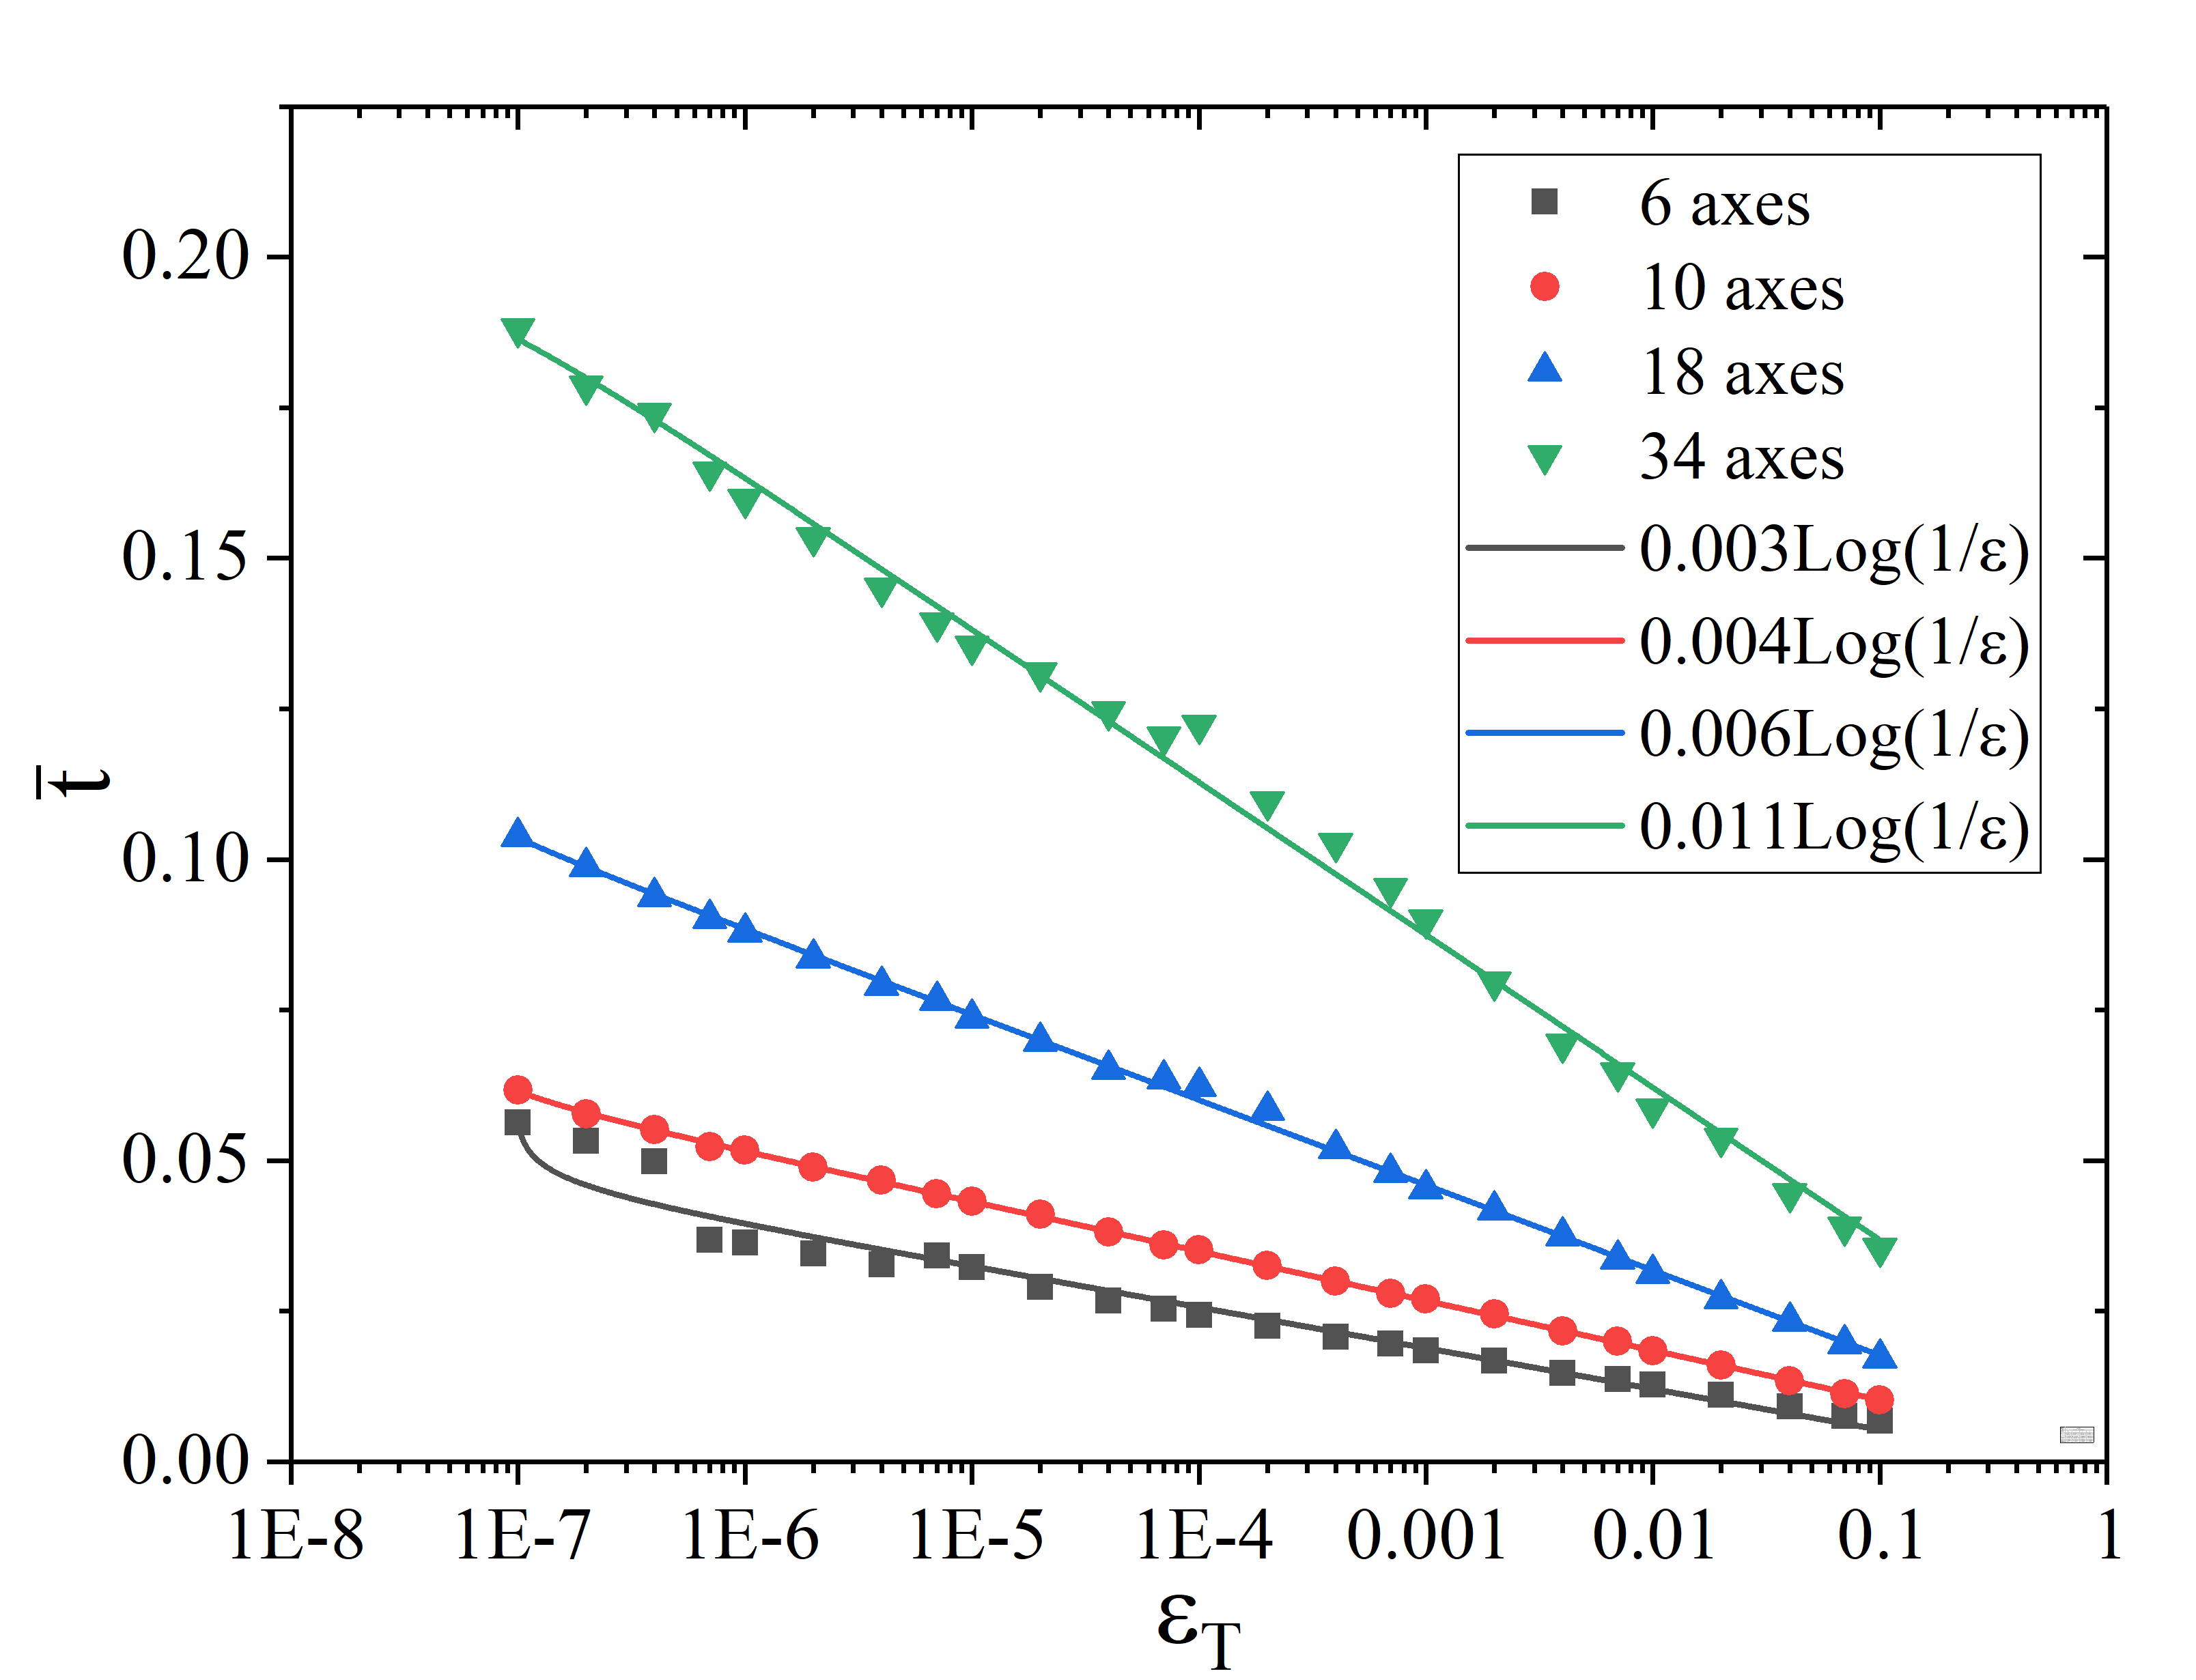